# Simple cantilever for load-controlled sensitivity analysis

This document will teach you how to use opstool to post-process sensitivity analysis.

- The source code see [14.8.1. Simple cantilever for load-controlled sensitivity analysis](https://openseespydoc.readthedocs.io/en/latest/src/CantileverSensitivity2D_v1.html).

- The numerical model with the associated analysis was described in detail by Prof. Michael Scott within 
  [OpenSees Days 2011](https://opensees.berkeley.edu/OpenSees/workshops/OpenSeesDays2011/B5_MHS.pdf).

![image.png](https://s2.loli.net/2025/03/30/6GFNVaJcfDeRLiC.png)

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops

import opstool as opst


## OpenSees Model

Use the unit system provided by opstool:

In [2]:
UNIT = opst.pre.UnitSystem(length="m", force="kN", time="sec")

In [3]:
# Angle
rad = 1.0
deg = np.pi / 180.0 * rad
g = 9.80665 * UNIT.m / (UNIT.sec**2)


### Define model  

In [4]:
# Create ModelBuilder
# -------------------
ops.wipe()
ops.model("basic", "-ndm", 2, "-ndf", 3)

# Create nodes
# ------------
L = 5 * UNIT.m
ops.node(1, 0.0, 0.0)  # Fixed end
ops.node(2, L, 0.0)  # Free end

# Fixed support
# -------------
ops.fix(1, 1, 1, 1)

# Define material
# ---------------
matTag = 1
Fy = 410 * UNIT.MPa  # Yield stress
Es = 200 * UNIT.GPa  # Modulus of Elasticity of Steel
b = 2 / 100  # 2% Strain hardening ratio
Hkin = b / (1 - b) * Es

# Sensitivity-ready steel materials: Hardening, Steel01, SteelMP, BoucWen, SteelBRB, StainlessECThermal, SteelECThermal, ...
# Hardening Sensitivity Params: sigmaY/fy/Fy, E, H_kin/Hkin, H_iso/Hiso
ops.uniaxialMaterial("Hardening", matTag, Es, Fy, 0, Hkin)

# ops.uniaxialMaterial("Steel01", matTag, Fy, Es, b) # Sensitivity Params: sigmaY/fy/Fy, E, b, a1, a2, a3, a4
# ops.uniaxialMaterial("SteelMP", matTag, Fy, Es, b) # Sensitivity Params: sigmaY/fy, E, b

# Define sections
# ---------------
# Sections defined with "canned" section ("WFSection2d"), otherwise use a FiberSection object (ops.section("Fiber",...))
beamSecTag = 1
beamWidth, beamDepth = 10 * UNIT.cm, 50 * UNIT.cm
#                          secTag,     matTag, d,         tw,        bf,       tf, Nfw, Nff
ops.section("WFSection2d", beamSecTag, matTag, beamDepth, beamWidth, beamWidth, 0, 20, 0)  # Beam section

# Define elements
# ---------------
beamTransTag, beamIntTag = 1, 1
# Linear, PDelta, Corotational
ops.geomTransf("Corotational", beamTransTag)

nip = 5
# Lobatto, Legendre, NewtonCotes, Radau, Trapezoidal, CompositeSimpson
ops.beamIntegration("Legendre", beamIntTag, beamSecTag, nip)

# Beam elements
numEle = 5
meshSize = L / numEle  # mesh size

eleType = "dispBeamColumn"  # forceBeamColumn, "dispBeamColumn"
#           tag, Npts, nodes, type, dofs, size, eleType, transfTag,    beamIntTag
ops.mesh("line", 1, 2, *[1, 2], 0, 3, meshSize, eleType, beamTransTag, beamIntTag)

# Create a Plain load pattern with a Sine/Trig TimeSeries
# -------------------------------------------------------
#                 tag, tStart, tEnd, period, factor
ops.timeSeries("Trig", 1, 0.0, 1.0, 1.0, "-factor", 1.0)  # "Sine", "Trig" or "Triangle"
ops.pattern("Plain", 1, 1)

P = 1710 * UNIT.kN
# Create nodal loads at node 2
#       nd  FX   FY  MZ
ops.load(2, 0.0, P, 0.0)

### Define Sensitivity Parameters   

In [5]:
# /// Each parameter must be unique in the FE domain, and all parameter tags MUST be numbered sequentially starting from 1! ///
ops.parameter(1)  # Blank parameters
ops.parameter(2)
ops.parameter(3)
ops.parameter(4)
for ele in range(1, numEle + 1):  # Only column elements
    ops.addToParameter(1, "element", ele, "E")  # E
    # Check the sensitivity parameter names in *.cpp files ("sigmaY" or "fy" or "Fy")
    # https://github.com/OpenSees/OpenSees/blob/master/SRC/material/uniaxial/HardeningMaterial.cpp
    ops.addToParameter(2, "element", ele, "Fy")  # "sigmaY" or "fy" or "Fy"
    ops.addToParameter(3, "element", ele, "Hkin")  # "H_kin" or "Hkin" or "b"
    ops.addToParameter(4, "element", ele, "d")  # "d"

ops.parameter(5, "node", 2, "coord", 1)  # parameter for coordinate of node 2 in DOF "1" (PX=1, PY=2, MZ=3)
# Map parameter 6 to vertical load at node 2 contained in load pattern 1 (last argument is global DOF, e.g., in 2D PX=1, PY=2, MZ=3)
ops.parameter(6, "loadPattern", 1, "loadAtNode", 2, 2)

# Parameter Symbols and Variables values
ParamSym = {1: "E", 2: "F_y", 3: "H_{kin}", 4: "d", 5: "L", 6: "P"}
ParamVars = {1: Es, 2: Fy, 3: Hkin, 4: beamDepth, 5: L, 6: P}

### Define Sensitivity Analysis

In [6]:
steps = 500
start_time = time.time()

ops.wipeAnalysis()
ops.system("BandGeneral")
ops.numberer("RCM")
ops.constraints("Transformation")
ops.test("NormDispIncr", 1.0e-12, 10, 3)
ops.algorithm("Newton")  # KrylovNewton
ops.integrator("LoadControl", 1 / steps)
ops.analysis("Static")
ops.sensitivityAlgorithm("-computeAtEachStep")  # automatically compute sensitivity at the end of each step

### Define the output data base and save the data

In [7]:
ODB = opst.post.CreateODB(odb_tag="sensitivity", save_sensitivity_resp=True)
for i in range(steps):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

print("Sensitvity Analysis Completed!")
print(f"Analysis elapsed time is {(time.time() - start_time):.3f} seconds.\n")

OPSTOOL ::  All responses data with _odb_tag = sensitivity saved in .opstool.output/RespStepData-sensitivity.nc!

Sensitvity Analysis Completed!
Analysis elapsed time is 0.742 seconds.



## Post-processing

We want to process the response of node 2 on degree of freedom UY:

In [8]:
ctrlNode = 2
dof = "UY"

### Loading node response

In [9]:
node_resp = opst.post.get_nodal_responses(odb_tag="sensitivity")
print("data variables:", node_resp.data_vars)
print("-" * 100)
print("dimensions:", node_resp.dims)
print("-" * 100)
print("coordinates:", node_resp.coords)

OPSTOOL ::  Loading all response data from .opstool.output/RespStepData-sensitivity.nc ...

data variables: Data variables:
    disp                (time, nodeTags, DOFs) float32 72kB 0.0 0.0 ... -0.8291
    vel                 (time, nodeTags, DOFs) float32 72kB 0.0 0.0 ... 0.0 0.0
    accel               (time, nodeTags, DOFs) float32 72kB 0.0 0.0 ... 0.0 0.0
    reaction            (time, nodeTags, DOFs) float32 72kB 0.0 ... -3.176e-10
    reactionIncInertia  (time, nodeTags, DOFs) float32 72kB 0.0 ... -3.176e-10
    rayleighForces      (time, nodeTags, DOFs) float32 72kB 0.0 0.0 ... 0.0 0.0
    pressure            (time, nodeTags) float32 12kB 0.0 0.0 0.0 ... 0.0 0.0
----------------------------------------------------------------------------------------------------
dimensions: FrozenMappingWarningOnValuesAccess({'time': 501, 'nodeTags': 6, 'DOFs': 6})
----------------------------------------------------------------------------------------------------
coordinates: Coordinates:
  * time      (time) float64 4kB 0.0 0.002 0.004 0.006 ... 0.994 0.996 0.998 1.0
  * nodeTags  (

We use the ``.sel`` method to retrieve the displacement of node 2 on UY and total reaction force:

In [10]:
times = node_resp["time"].data
disp = node_resp["disp"].sel(nodeTags=ctrlNode, DOFs=dof)
force = -node_resp["reaction"].sel(DOFs=dof).sum(dim="nodeTags")

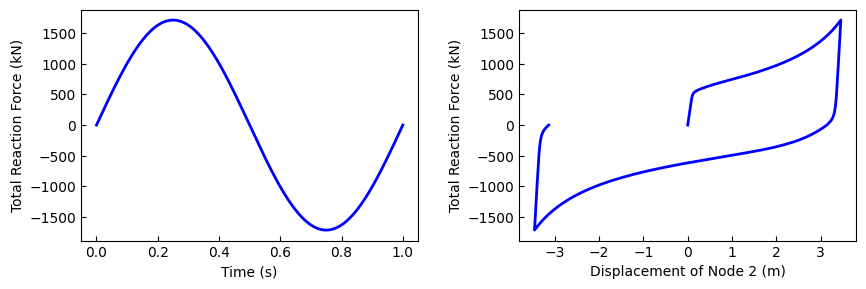

In [11]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(times, force, lw=2, color="blue")
axs[0].set_xlabel("Time (s)")
axs[1].plot(disp, force, lw=2, color="blue")
axs[1].set_xlabel("Displacement of Node 2 (m)")
for ax in axs:
    ax.set_ylabel("Total Reaction Force (kN)")
    # ax.grid()
plt.subplots_adjust(wspace=0.3)
plt.show()

### Loading the sensitivity response data

In [12]:
sens_resp = opst.post.get_sensitivity_responses(odb_tag="sensitivity")
print("data variables:", sens_resp.data_vars)
print("-" * 100)
print("dimensions:", sens_resp.dims)
print("-" * 100)
print("coordinates:", sens_resp.coords)

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-sensitivity.nc ...

data variables: Data variables:
    disp      (time, paraTags, nodeTags, DOFs) float32 433kB 0.0 ... 0.0007176
    vel       (time, paraTags, nodeTags, DOFs) float32 433kB 0.0 0.0 ... 0.0 0.0
    accel     (time, paraTags, nodeTags, DOFs) float32 433kB 0.0 0.0 ... 0.0 0.0
    pressure  (time, paraTags, nodeTags) float32 72kB 0.0 0.0 0.0 ... 0.0 0.0
    lambdas   (time, paraTags, patternTags) float32 12kB 0.0 0.0 0.0 ... 0.0 0.0
----------------------------------------------------------------------------------------------------
dimensions: FrozenMappingWarningOnValuesAccess({'time': 501, 'paraTags': 6, 'nodeTags': 6, 'DOFs': 6, 'patternTags': 1})
----------------------------------------------------------------------------------------------------
coordinates: Coordinates:
  * paraTags     (paraTags) int32 24B 1 2 3 4 5 6
  * nodeTags     (nodeTags) int32 24B 1 2 3 4 5 6
  * DOFs         (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
  * patternTags  (patternTags) int32 4B 1


Get all parameter tags:

In [13]:
paraTags = sens_resp.paraTags.data
print("parameter tags:", paraTags)

parameter tags: [1 2 3 4 5 6]


### Sensitivity of node 2 displacement to various parameters

Get the displacement sensitivity of the control node on the specified degree of freedom, which stores the sensitivity of each parameter.

``paraTags`` refers to each parameter.

In [14]:
sens_disp = sens_resp["disp"].sel(nodeTags=ctrlNode, DOFs=dof)
print(sens_disp)

<xarray.DataArray 'disp' (time: 501, paraTags: 6)> Size: 12kB
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [-2.1541734e-11,  0.0000000e+00,  0.0000000e+00, -2.5850082e-02,
         2.5850094e-03,  2.0050080e-04],
       [-4.3079776e-11,  0.0000000e+00,  0.0000000e+00, -5.1695731e-02,
         5.1695835e-03,  2.0049945e-04],
       ...,
       [-6.3095079e-10,  4.0031543e-07,  2.9350488e-07,  7.0663419e+00,
        -1.0906913e+00,  1.8918514e-03],
       [-6.0609201e-10, -7.3395910e-08,  3.0900600e-07,  6.7016916e+00,
        -1.0734695e+00,  2.0630800e-03],
       [-5.5527172e-10, -6.1019131e-07,  3.2541715e-07,  6.2845788e+00,
        -1.0527800e+00,  2.2677963e-03]], dtype=float32)
Coordinates:
  * paraTags  (paraTags) int32 24B 1 2 3 4 5 6
    nodeTags  int32 4B 2
    DOFs      <U2 8B 'UY'
Dimensions without coordinates: time


### Plotting

The left column shows the sensitivity of displacement $U$ to each parameter $P$ and the product of the parameter value:
$$ \left( \partial U/\partial {P} \right){P} $$

The right column shows the hysteresis diagram of displacement $U$ and total reaction force $F$, where the displacement includes a sensitivity change of 0.1 times, i.e., $0.1 \left( \partial U/\partial {P} \right){P}$

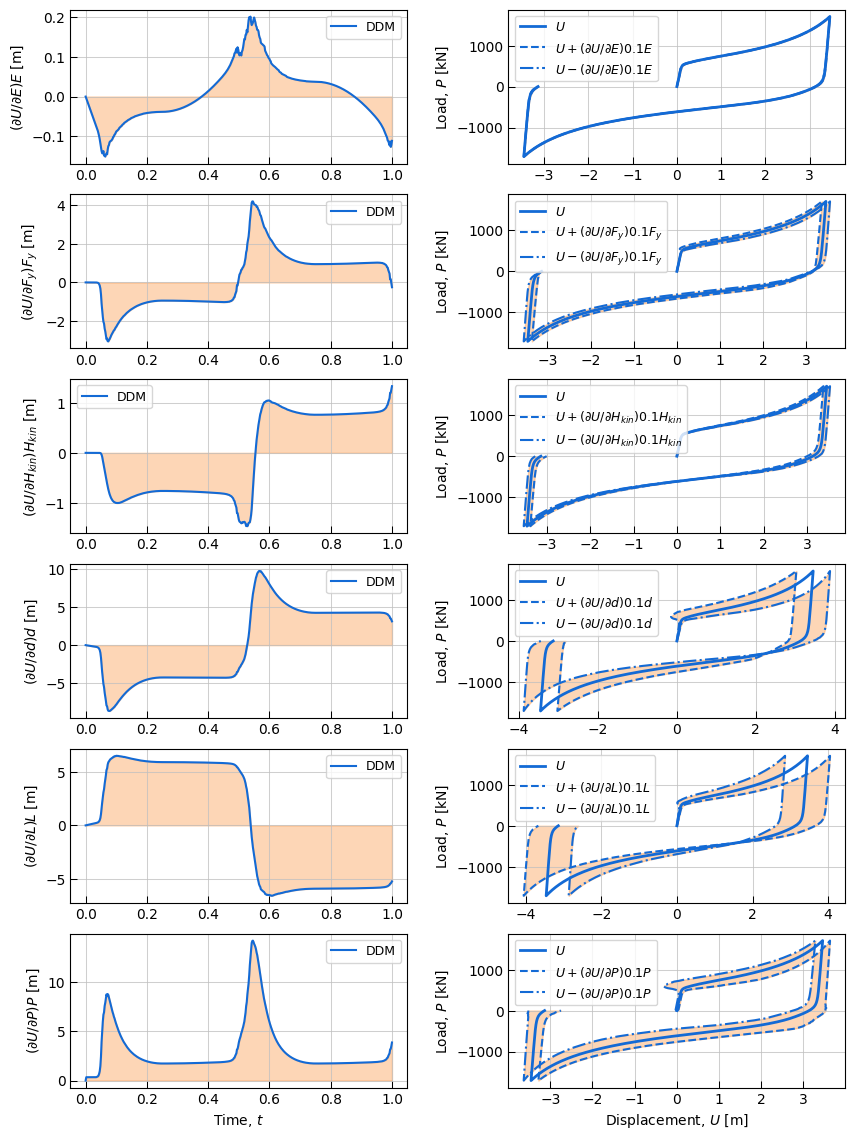

In [15]:
fig, axs = plt.subplots(6, 2, figsize=(5 * 2, 2 * 7))

for j, para_tag in enumerate(paraTags):
    para_value = ParamVars[para_tag]
    para_sym = ParamSym[para_tag]
    sens = sens_disp.sel(paraTags=para_tag)
    # Subplot #i
    # ----------
    axs[j, 0].plot(times, sens * para_value, c="#136ad5", linewidth=1.5, label="DDM")
    axs[j, 0].fill_between(times, sens * para_value, 0.0, color="#fb8a2e", alpha=0.35)
    axs[j, 0].set_ylabel(f"$(\\partial U/\\partial {para_sym}){para_sym}$ [m]")
    axs[j, 0].legend(fontsize=9)
    if j == 5:
        axs[j, 0].set_xlabel(r"Time, $t$")

    # Subplot #ii
    # -----------
    axs[j, 1].plot(disp, force, c="#136ad5", linewidth=2.0, label="$U$")
    axs[j, 1].plot(
        disp + sens * 0.1 * para_value,
        force,
        c="#136ad5",
        ls="--",
        linewidth=1.5,
        label=f"$U + (\\partial U/\\partial {para_sym})0.1{para_sym}$",
    )
    axs[j, 1].plot(
        disp - sens * 0.1 * para_value,
        force,
        c="#136ad5",
        ls="-.",
        linewidth=1.5,
        label=f"$U - (\\partial U/\\partial {para_sym})0.1{para_sym}$",
    )
    axs[j, 1].fill_betweenx(
        force, disp + sens * 0.1 * para_value, disp - sens * 0.1 * para_value, color="#fb8a2e", alpha=0.35
    )

    axs[j, 1].set_ylabel(r"Load, $P$ [kN]")
    axs[j, 1].legend(fontsize=9)
    if j == 5:
        axs[j, 1].set_xlabel(r"Displacement, $U$ [m]")

for ax in axs.flat:
    ax.tick_params(direction="in", length=5, colors="k", width=0.75)
    ax.grid(True, color="silver", linestyle="solid", linewidth=0.75, alpha=0.75)
plt.subplots_adjust(wspace=0.3)
plt.show()